In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install shap
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.7 MB/s eta 0:00:00


Acurácia do Random Forest: 0.9189
Acurácia do SVM: 0.9929
Acurácia do Logistic Regression: 1.0000
Acurácia do K-Nearest Neighbors: 0.8806
Acurácia do Naive Bayes: 0.8749
Acurácia do XGBoost: 0.9461
Acurácia do Decision Tree: 0.8051


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Acurácia do AdaBoost: 0.7276
Acurácia do CatBoost: 0.9832


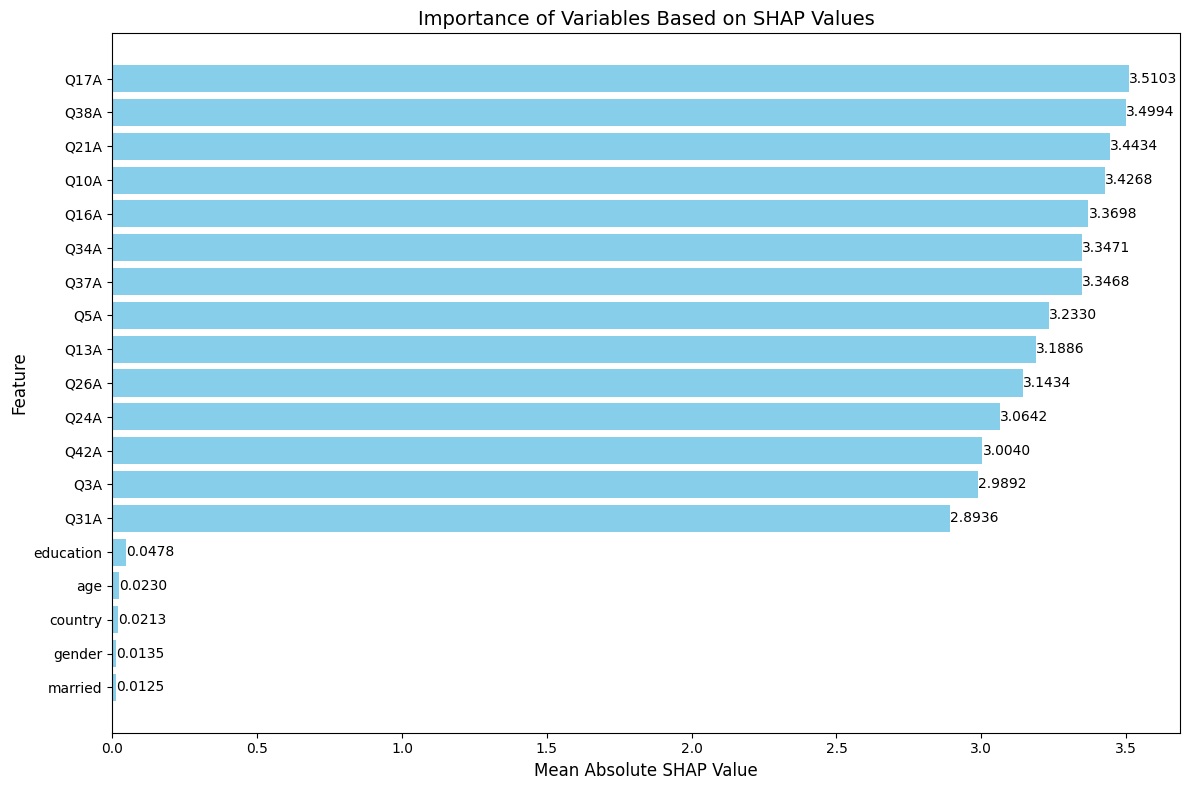

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from google.colab import files
import numpy as np
import shap
import matplotlib.pyplot as plt
import json

def prever_indice_depressao(data):
    X = data.drop(columns=['soma_depressao', 'indice_depressao'])
    y = data['indice_depressao']

    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

    # Dicionário de modelos
    modelos = {
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(),
        'Logistic Regression': LogisticRegression(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Naive Bayes': GaussianNB(),
        'XGBoost': XGBClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'CatBoost': CatBoostClassifier(verbose=0),
    }

    modelos_treinados = {}
    metricas_modelos = {}

    for nome, modelo in modelos.items():
        modelo.fit(X_train_scaled, y_train)
        y_pred = modelo.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        modelos_treinados[nome] = {'modelo': modelo, 'accuracy': accuracy}
        metricas_modelos[nome] = accuracy  # Armazenar as acurácias para o JSON
        print(f"Acurácia do {nome}: {accuracy:.4f}")  # Imprimir a acurácia de cada modelo

    joblib.dump(modelos_treinados, 'modelos_treinados.pkl')

    # Salvar as métricas no JSON
    with open('/content/drive/My Drive/ComparativoAMDepressao/metricas_modelos.json', 'w') as f:
        json.dump(metricas_modelos, f)

    return modelos_treinados, X_train_scaled, X_test_scaled, y_train, y_test

# Função para calcular a importância das variáveis com SHAP
def calcular_shap_importance_logistic_regression(X_train_scaled, X_test_scaled, modelo):
    # Inicializar o explicador SHAP apropriado para modelos lineares
    explainer = shap.Explainer(modelo, X_train_scaled)

    shap_values = explainer(X_test_scaled)

    #  matriz completa de valores SHAP
    shap_values_df = pd.DataFrame(shap_values.values.reshape(-1, shap_values.values.shape[1]), columns=X_test_scaled.columns)
    shap_values_df.to_csv('/content/drive/My Drive/ComparativoAMDepressao/shap_values_matrix.csv', index=False)

    # Calcular a importância média das variáveis
    shap_importance = np.mean(np.abs(shap_values.values), axis=(0, 2))  # Média sobre as amostras e classes

    shap_importance_df = pd.DataFrame({
        'Feature': X_test_scaled.columns,
        'Mean Absolute SHAP Value': shap_importance
    })

    # ordenar por importância
    shap_importance_df = shap_importance_df.sort_values(by='Mean Absolute SHAP Value', ascending=False)

    # info do gráfico a serem salvas
    grafico_info = {
        "features": shap_importance_df['Feature'].tolist(),
        "mean_abs_shap_values": shap_importance_df['Mean Absolute SHAP Value'].tolist(),
        "color": "skyblue",
        "figsize": (12, 8),
        "xlabel": "Mean Absolute SHAP Value",
        "ylabel": "Feature",
        "title": "Importância das Variáveis com Base nos Valores SHAP",
        "save_path": '/content/drive/My Drive/ComparativoAMDepressao/shap_importance_plot.png'
    }

    # Salvararquivo JSON
    with open('/content/drive/My Drive/ComparativoAMDepressao/grafico_info.json', 'w') as f:
        json.dump(grafico_info, f)

    plt.figure(figsize=(12, 8))
    plt.barh(shap_importance_df['Feature'], shap_importance_df['Mean Absolute SHAP Value'], color='skyblue')
    plt.xlabel('Mean Absolute SHAP Value', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Importance of Variables Based on SHAP Values', fontsize=14)
    plt.gca().invert_yaxis()  # Inverter o eixo y para mostrar as variáveis mais importantes no topo
    plt.tight_layout()

    for index, value in enumerate(shap_importance_df['Mean Absolute SHAP Value']):
        plt.text(value, index, f'{value:.4f}', va='center')

    plt.savefig(grafico_info['save_path'])

    plt.show()

# Carregar os dados
file_path = '/content/drive/My Drive/calc/dataset.csv'
data = pd.read_csv(file_path)

# Treinar e salvar os modelos
modelos_treinados, X_train_scaled, X_test_scaled, y_train, y_test = prever_indice_depressao(data)

calcular_shap_importance_logistic_regression(X_train_scaled, X_test_scaled, modelos_treinados['Logistic Regression']['modelo'])

# Fazer o download dos arquivos de modelos e JSONs
files.download('modelos_treinados.pkl')
files.download('/content/drive/My Drive/ComparativoAMDepressao/grafico_info.json')
files.download('/content/drive/My Drive/ComparativoAMDepressao/metricas_modelos.json')


In [ ]:
import pandas as pd

file_path = '/content/drive/My Drive/calc/dataset.csv'
data = pd.read_csv(file_path)

# Novo dicionário mapeando números de países para os respectivos códigos ISO atualizados
country_dict = {
    1: 'AE', 2: 'AR', 3: 'AT', 4: 'AU', 5: 'BE', 6: 'BN', 7: 'BR', 8: 'CA', 9: 'CH', 10: 'CZ',
    11: 'DE', 12: 'DK', 13: 'EG', 14: 'ES', 15: 'FI', 16: 'FR', 17: 'GB', 18: 'GR', 19: 'HK', 20: 'HR',
    21: 'HU', 22: 'ID', 23: 'IE', 24: 'IN', 25: 'IT', 26: 'JM', 27: 'JP', 28: 'MX', 29: 'MY', 30: 'NL',
    31: 'NO', 32: 'NZ', 33: 'PH', 34: 'PK', 35: 'PL', 36: 'PT', 37: 'RO', 38: 'RS', 39: 'RU', 40: 'SA',
    41: 'SE', 42: 'SG', 43: 'TR', 44: 'US', 45: 'VN', 46: 'ZA'
}

# Dicionário 
country_name_dict = {
    'AE': 'United Arab Emirates', 'AR': 'Argentina', 'AT': 'Austria', 'AU': 'Australia', 'BE': 'Belgium',
    'BN': 'Brunei', 'BR': 'Brazil', 'CA': 'Canada', 'CH': 'Switzerland', 'CZ': 'Czech Republic',
    'DE': 'Germany', 'DK': 'Denmark', 'EG': 'Egypt', 'ES': 'Spain', 'FI': 'Finland', 'FR': 'France',
    'GB': 'United Kingdom', 'GR': 'Greece', 'HK': 'Hong Kong', 'HR': 'Croatia', 'HU': 'Hungary',
    'ID': 'Indonesia', 'IE': 'Ireland', 'IN': 'India', 'IT': 'Italy', 'JM': 'Jamaica', 'JP': 'Japan',
    'MX': 'Mexico', 'MY': 'Malaysia', 'NL': 'Netherlands', 'NO': 'Norway', 'NZ': 'New Zealand',
    'PH': 'Philippines', 'PK': 'Pakistan', 'PL': 'Poland', 'PT': 'Portugal', 'RO': 'Romania', 'RS': 'Serbia',
    'RU': 'Russia', 'SA': 'Saudi Arabia', 'SE': 'Sweden', 'SG': 'Singapore', 'TR': 'Turkey', 'US': 'United States',
    'VN': 'Vietnam', 'ZA': 'South Africa'
}

# dicionário para mapear países para continentes
continent_dict = {
    'AE': 'Asia', 'AR': 'South America', 'AT': 'Europe', 'AU': 'Australia/New Zealand', 'BE': 'Europe', 'BN': 'Asia',
    'BR': 'South America', 'CA': 'North America', 'CH': 'Europe', 'CZ': 'Europe', 'DE': 'Europe', 'DK': 'Europe',
    'EG': 'Africa', 'ES': 'Europe', 'FI': 'Europe', 'FR': 'Europe', 'GB': 'Europe', 'GR': 'Europe', 'HK': 'Asia',
    'HR': 'Europe', 'HU': 'Europe', 'ID': 'Asia', 'IE': 'Europe', 'IN': 'Asia', 'IT': 'Europe', 'JM': 'North America',
    'JP': 'Asia', 'MX': 'North America', 'MY': 'Asia', 'NL': 'Europe', 'NO': 'Europe', 'NZ': 'Australia/New Zealand',
    'PH': 'Asia', 'PK': 'Asia', 'PL': 'Europe', 'PT': 'Europe', 'RO': 'Europe', 'RS': 'Europe', 'RU': 'Europe',
    'SA': 'Asia', 'SE': 'Europe', 'SG': 'Asia', 'TR': 'Asia', 'US': 'North America', 'VN': 'Asia', 'ZA': 'Africa'
}

# Verificar se as colunas 'country' e 'indice_depressao' estão no dataset
if 'country' in data.columns and 'indice_depressao' in data.columns:
    # Mapear os números de país para seus códigos ISO e continentes
    data['country_code'] = data['country'].map(country_dict)
    data['continent'] = data['country_code'].map(continent_dict)

    # Verificar se o mapeamento foi realizado corretamente
    print("Exemplo de mapeamento de países para códigos ISO e continentes:")
    print(data[['country', 'country_code', 'continent']].head())

    # Contagem de participantes por continente
    continent_counts = data['continent'].value_counts()

    for continent in continent_counts.index:
        print(f"\nContinente: {continent}, Total de participantes: {continent_counts[continent]}")
        countries_in_continent = data[data['continent'] == continent]['country_code'].value_counts()

        continent_avg_depression = 0
        country_count = 0

        for country_code, count in countries_in_continent.items():
            avg_depression = data[data['country_code'] == country_code]['indice_depressao'].mean()
            country_name = country_name_dict[country_code]  # Obter o nome do país
            print(f"  País: {country_name}, Participantes: {count}, Média do Índice de Depressão: {avg_depression:.2f}")

            # Somar para calcular a média do continente
            continent_avg_depression += avg_depression
            country_count += 1

        continent_avg_depression /= country_count
        print(f"Média do Índice de Depressão no Continente ({continent}): {continent_avg_depression:.2f}")

    # Exibir a soma total de todos os participantes
    total_participants = continent_counts.sum()
    print(f"\nTotal de participantes em todos os continentes: {total_participants}")

else:
    print("As colunas 'country' ou 'indice_depressao' não foram encontradas no dataset.")


Exemplo de mapeamento de países para códigos ISO e continentes:
   country country_code continent
0        1           AE      Asia
1        1           AE      Asia
2        1           AE      Asia
3        1           AE      Asia
4        1           AE      Asia

Continente: Asia, Total de participantes: 16652
  País: Malaysia, Participantes: 14538, Média do Índice de Depressão: 2.15
  País: Indonesia, Participantes: 559, Média do Índice de Depressão: 2.33
  País: Philippines, Participantes: 456, Média do Índice de Depressão: 2.49
  País: India, Participantes: 307, Média do Índice de Depressão: 2.19
  País: Singapore, Participantes: 179, Média do Índice de Depressão: 2.24
  País: Brunei, Participantes: 126, Média do Índice de Depressão: 2.34
  País: Japan, Participantes: 90, Média do Índice de Depressão: 1.84
  País: Turkey, Participantes: 83, Média do Índice de Depressão: 2.54
  País: Pakistan, Participantes: 81, Média do Índice de Depressão: 2.43
  País: Hong Kong, Participantes